Script to look for high mass galaxies in the EAGLE simulation and make images of them, so that we can look at their H$\alpha$ distributions, see if we can look for inflows and such.

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from scipy.ndimage import morphology
from skimage import morphology as skimagemorphology

import get_halpha_SB

%run 'load_data.ipynb'
%run 'add_noise.ipynb'
%run 'extract_FOV.ipynb'
%matplotlib inline

In [2]:
machine = 'chinook'

In [3]:
### STUFF WE MUST HAVE:
slicewidth = 5.        # initial value
resolution = None      # initial value   # arcsec/pixel
distance   = '100Mpc'  # initial value
data_FOV =None  # from extract_FOV
xystarts =None  # from extract_FOV
size     =None  # from extract_FOV

data_tuple = loaddata(machine=machine, distance=distance, slicewidth=slicewidth)  ### I want this to set the resolution too

Resolution is None, finding minimum resolution of the similuation...
The resolution of the raw simulation at 100Mpc is 6.40094057981.
Loading data of slicewidth 5 (after rounding), number of slices is 1
./intermediatedata/data_100Mpc_6arcsec_5slwd.npz exists, loading now...
./intermediatedata/data_100Mpc_6arcsec_5slwd.npz was not saved as a tuple since too large, returning as tuple with 32000,1 appended.


In [4]:
resolution = 6.4
verbose=True

In [5]:
import eagleSqlTools as sql

def searchgals(xmin,xmax,ymin,ymax,zmin,zmax):
    
    mySim = ('RefL0100N1504',100.)
    con   = sql.connect("dlokhorst",password="mxdPB54Y")  

    myQuery  = "SELECT \
                SH.GalaxyID, \
                SH.StarFormationRate as SFR, \
                SH.CentreOfPotential_x, \
                SH.CentreOfPotential_y, \
                SH.CentreOfPotential_z, \
                SH.SubGroupNumber, \
                SH.MassType_Star, \
                SH.HalfMassProjRad_Gas, \
                SH.HalfMassProjRad_Star \
            FROM \
                %s_SubHalo as SH \
            WHERE \
                SH.SnapNum = 28 and \
                SH.CentreOfPotential_x >= %s and \
                SH.CentreOfPotential_x <= %s and \
                SH.CentreOfPotential_y >= %s and \
                SH.CentreOfPotential_y <= %s and \
                SH.CentreOfPotential_z >= %s and \
                SH.CentreOfPotential_z <= %s and \
                SH.MassType_Star > 0 "%('RefL0100N1504',xmin,xmax,ymin,ymax,zmin,zmax)
 

                #  and \
              #  SH.StarFormationRate > 0.00001 

    if verbose:
        print myQuery
    
    myData = sql.execute_query(con,myQuery)

    xgal = myData['CentreOfPotential_x'][:]   # cMpc
    ygal = myData['CentreOfPotential_y'][:]   # cMpc
    #z = myData['CentreOfMass_z'][:]
    mgal = myData['MassType_Star'][:]         # M_solar
    rhgas = myData['HalfMassProjRad_Gas'][:]  # pkpc
    rhstar= myData['HalfMassProjRad_Star'][:] # pkpc
    
    return xgal,ygal,mgal,rhgas,rhstar

In [6]:
xmin=0;xmax=100;ymin=0;ymax=100;zmin=10;zmax=15
xgal,ygal,mgal,rhgas,rhstar = searchgals(xmin,xmax,ymin,ymax,zmin,zmax)

SELECT                 SH.GalaxyID,                 SH.StarFormationRate as SFR,                 SH.CentreOfPotential_x,                 SH.CentreOfPotential_y,                 SH.CentreOfPotential_z,                 SH.SubGroupNumber,                 SH.MassType_Star,                 SH.HalfMassProjRad_Gas,                 SH.HalfMassProjRad_Star             FROM                 RefL0100N1504_SubHalo as SH             WHERE                 SH.SnapNum = 28 and                 SH.CentreOfPotential_x >= 0 and                 SH.CentreOfPotential_x <= 100 and                 SH.CentreOfPotential_y >= 0 and                 SH.CentreOfPotential_y <= 100 and                 SH.CentreOfPotential_z >= 10 and                 SH.CentreOfPotential_z <= 15 and                 SH.MassType_Star > 0 


In [7]:
Mpcperpix = 0.477/1000.*(1.+0.0235) * 6.4
        
# Condition (use bitwise "&" and not boolean "and")
condition_8to9 = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                              (rhgas*5.  > (Mpcperpix*1000.)) &
                              (mgal > 10**8) & (mgal < 10**9)
                         )
condition_9to10 = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                               (rhgas*5. > (Mpcperpix*1000.)) &
                               (mgal > 10**9) & (mgal < 10**10)
                          )
condition_10andup = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                                 (rhgas*5. > (Mpcperpix*1000.)) &
                                 (mgal > 10**10) 
                            )
ii_8to9 = np.array(np.where(condition_8to9)[0]) 
ii_9to10 = np.array(np.where(condition_9to10)[0]) 
ii_10andup = np.array(np.where(condition_10andup)[0]) 

In [8]:
print len(ii_8to9), len(ii_9to10), len(ii_10andup)
xgal_10andup     = np.array(xgal[ii_10andup])
ygal_10andup     = np.array(ygal[ii_10andup])
mgal_10andup     = np.array(mgal[ii_10andup])
len(ygal_10andup)

909 350 171


171

In [22]:
def pltimg(data_FOV,ax,xystarts,size,label=None):
    colmap = 'viridis'
    ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
    img = ax.imshow(data_FOV.T,extent=(xystarts[0],xystarts[0]+size[0],xystarts[1],xystarts[1]+size[1]),\
                    origin='lower', cmap=cm.get_cmap(colmap),interpolation='nearest')
    div = axgrid.make_axes_locatable(ax)
    cax = div.append_axes("top",size="5%",pad=0.1)
    cbar = plt.colorbar(img, cax=cax,orientation='horizontal')
    if label is not None:
        ax.text(0.0,0.9,label,transform=ax.transAxes,color='white')

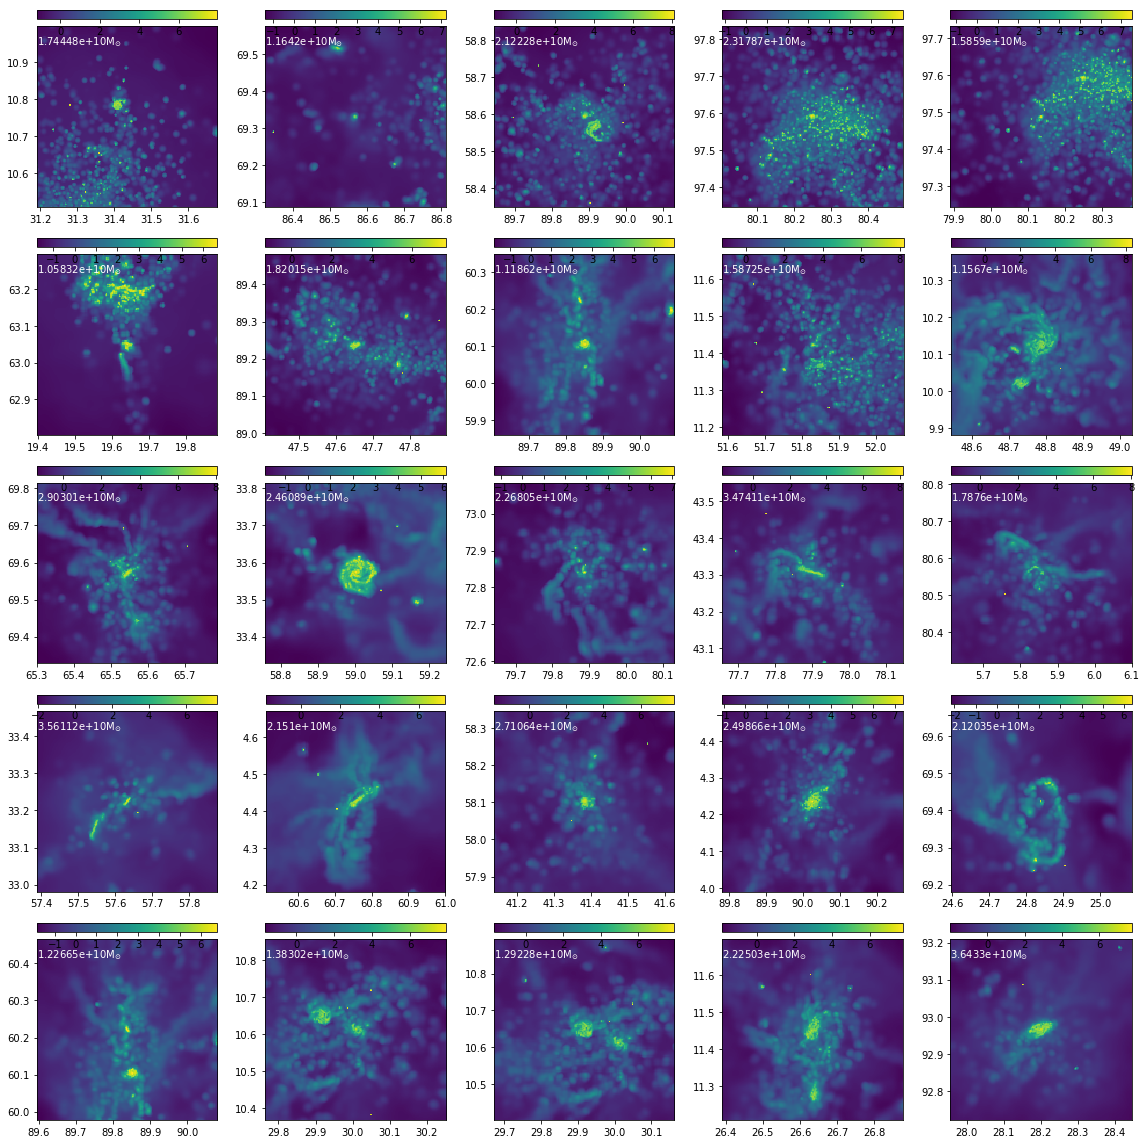

In [25]:
f, axarr = plt.subplots(5, 5,figsize=(16,16))

for j in range(25):
    data_tiny, xystarts_tiny, size_tiny = extractFOV(data_tuple,resolution,distance,\
                                                     x_center=xgal_10andup[j],y_center=ygal_10andup[j],\
                                                     x_angFOV=1000.,y_angFOV=1000.)
    pltimg(data_tiny,axarr[j/5,j%5],xystarts_tiny,size_tiny,label=r'%sM$_{\odot}$'%mgal_10andup[j])  
plt.tight_layout()

Change the x and y labels to just DeltaX and DeltaY in either Mpc or arcsec (or both) since the location are not terribly informative.